# Final Project Submission

Please fill out:
* Student name: Hiten Patel 
* Student pace: Full Time Online 
* Scheduled project review date/time: 10/17: 1pm
* Instructor name: James Irving 
* Blog post URL: https://hpatel530.github.io/blog_number_4_by_hiten_patel


# Chicago Car Crash: Predicting the Cause of Traffic Accidents 

This project is based on the Chicago Car Crash data. We will use this data to create a model which will help predict why car accidents occur.

An average span of four days, Chicago can record up to over a thousand car accidents. When you include drivers, passengers, pedestrians and cyclists, up to two thousand people can be effected. Forty-five percent of the people will experience a minor to fatal injury. 

The purpose of this project is to build a classification model to help identify what features are important in a car accident. 



# Obtain 

## Import Packages 

In [1]:
#!pip install scikit-learn==0.23.2

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

from sklearn.compose import ColumnTransformer

#!pip install shap
import shap 
shap.initjs()

import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import folium 

import warnings
warnings.filterwarnings('ignore')

/Users/Hiten.K.Patel/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


## Functions 

In [2]:
def evaluate_classification(model, X_train_tf, X_test_tf, y_train, y_test, classes = None, 
                            normalize = 'true', cmap='summer', label = ''):
    
    """Input a model, training data and test data to return sklearn metrics
        - Classification Report for training and test 
        - Confusion Matrix for training and test 
        - ROC Curve for training and test 
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train_tf: train_test_split & preprocessed
        X_test_tf: train_test_split & preprocessed
        y_train: train_test_split
        y_test: train_test_split 
        label: optional label for type of test 
        
        Modified Function, Citation:
        https://github.com/jirvingphd/fsds_070620_FT_cohort_notes/blob/master/Mod_3/
        mod_3_classification_project/bonus%20notebooks/classification_project_OH1_pipelines_SHAP%20.ipynb
        
    """
    # retrieve predictions for train and test data 
    y_pred_train = model.predict(X_train_tf)
    y_pred_test = model.predict(X_test_tf)
    
    # print training classification report 
    header = label + " CLASSIFICATION REPORT TRAINING "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names = classes))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(10,4), ncols=2)
    
    # confusion matrix 
    plot_confusion_matrix(model, X_train_tf, y_train, labels=classes, normalize = normalize,
                         cmap = cmap, ax=axes[0])
    
    axes[0].set(title = 'Confusion Matrix Training')
    
    # plot ROC curve 
    plot_roc_curve(model, X_train_tf, y_train, ax=axes[1])
    roc = axes[1]
    roc.legend()
    roc.plot([0,1], [0,1], ls=':')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Training')
    plt.show()
    
    # print testing classification report 
    header_ = label + " CLASSIFICATION REPORT TESTING "
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names = classes))
    
    # display training figures 
    fig, axes = plt.subplots(figsize=(10,4), ncols=2)
    
    # confusion matrix 
    plot_confusion_matrix(model, X_test_tf, y_test,  labels=classes, normalize = normalize, 
                          cmap = cmap, ax=axes[0])
  
    
    axes[0].set(title = 'Confusion Matrix Testing')
    
    # plot ROC curve 
    plot_roc_curve(model, X_test_tf, y_test, ax=axes[1])
    roc = axes[1]
    roc.legend()
    roc.plot([0,1], [0,1], ls=':')
    roc.grid()
    roc.set_title('Receiving Operator Characteristic Test')
    plt.show()

## Import Data

### Data Source 1/2/3: crash/vehicle/person

In [3]:
# import database one and observe 
pd.set_option('display.max_columns', None)
crash = pd.read_csv('https://data.cityofchicago.org/resource/85ca-t3if.csv')
vehicle = pd.read_csv('https://data.cityofchicago.org/resource/68nd-jvt3.csv')
person = pd.read_csv('https://data.cityofchicago.org/resource/u6pd-qa9d.csv')


### Merging Data = df 

In [4]:
# merging all three databases into 1, observing shape and previewing data 
merged = pd.merge(left=crash, right = vehicle, left_on='crash_record_id', right_on="crash_record_id")
df = pd.merge(left=merged, right=person, left_on = 'vehicle_id', right_on='vehicle_id')
print(df.shape)
df.head()

(1289, 149)


,crash_record_id_x,rd_no_x,crash_date_est_i,crash_date_x,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,lane_cnt,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,private_property_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,photos_taken_i,statements_taken_i,dooring_i,work_zone_i,work_zone_type,workers_present_i,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,rd_no_y,crash_date_y,unit_no,unit_type,num_passengers,vehicle_id,cmrc_veh_i,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,towed_i,fire_i,occupant_cnt,exceed_speed_limit_i,towed_by,towed_to,area_00_i,area_01_i,area_02_i,area_03_i,area_04_i,area_05_i,area_06_i,area_07_i,area_08_i,area_09_i,area_10_i,area_11_i,area_12_i,area_99_i,first_contact_point,cmv_id,usdot_no,ccmc_no,ilcc_no,commercial_src,gvwr,carrier_name,carrier_state,carrier_city,hazmat_placards_i,hazmat_name,un_no,hazmat_present_i,hazmat_report_i,hazmat_report_no,mcs_report_i,mcs_report_no,hazmat_vio_cause_crash_i,mcs_vio_cause_crash_i,idot_permit_no,wide_load_i,trailer1_width,trailer2_width,trailer1_length,trailer2_length,total_vehicle_length,axle_cnt,vehicle_config,cargo_body_type,load_type,hazmat_out_of_service_i,mcs_out_of_service_i,hazmat_class,person_id,person_type,crash_record_id_y,rd_no,crash_date,seat_no,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,hospital,ems_agency,ems_run_no,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,bac_result_value,cell_phone_use
0,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,NaN,NaN,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,N,"OVER $1,500",2020-10-18T22:48:00.000,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,NaN,NaN,NaN,NaN,NaN,NaN,4,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,2.0,0.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979246,NaN,2020-10-18T22:48:00.000,1,NON-CONTACT VEHICLE,NaN,927955.0,NaN,CHEVROLET,IMPALA,NaN,NaN,UNKNOWN,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O979246,NON-CONTACT VEHICLE,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,NaN,2020-10-18T22:48:00.000,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,OTHER,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,NaN,NaN,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,N,"OVER $1,500",2020-10-18T22:48:00.000,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,NaN,NaN,NaN,NaN,NaN,NaN,4,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,2.0,0.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979247,NaN,2020-10-18T22:48:00.000,2,DRIVER,1.0,927958.0,NaN,CHEVROLET,IMPALA,IL,2004.0,UNKNOWN,PASSENGER,PERSONAL,E,AVOIDING VEHICLES/OBJECTS,NaN,NaN,2.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [101]:
df.to_csv()

',traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,Injured,crash_day_of_week,unit_type,vehicle_type,sex,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_vision,time_bins,age_bins,posted_speed\n0,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED/FIXED,NOT DIVIDED,DRY,NO DEFECTS,N,321,1,1,NON-CONTACT VEHICLE,PASSENGER,X,,,USAGE UNKNOWN,NOT APPLICABLE/UNKNOWN,UNKNOWN,Late Evening,,26-40\n1,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED/FIXED,NOT DIVIDED,DRY,NO DEFECTS,N,321,1,1,DRIVER,PASSENGER,M,IN,,USAGE UNKNOWN,NOT APPLICABLE/UNKNOWN,UNKNOWN,Late Evening,36-55,26-40\n2,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED/FIXED,NOT DIVIDED,DRY,NO DEFECTS,N,321,1,1,DRIVER,PASSENGER,F,,,USAGE UNKNOWN,NOT APPLICABLE/UNKNOWN,,Late Evening,25-35,26-40\n3,TRAFFIC SIGNAL/SIGN,FUNCTIONING PROPERLY,CL

# Scrub 

## Calculating Nulls

In [5]:
# calculating nulls
nulls = df.isna().sum()
null_percent = nulls[nulls>0] / len(df)
null_percent.to_frame('% Null').style.background_gradient(cmap='Reds')

,% Null
rd_no_x,1.000000
crash_date_est_i,0.949573
lane_cnt,1.000000
report_type,0.003103
intersection_related_i,0.684251
private_property_i,0.941040
hit_and_run_i,0.688130
photos_taken_i,0.979829
statements_taken_i,0.977502
dooring_i,0.986036


In [6]:
# extracting columns with excesssive nulls which is set at 95%
Index_label = null_percent[null_percent>.70].index.tolist()
Index_label

['rd_no_x',
 'crash_date_est_i',
 'lane_cnt',
 'private_property_i',
 'photos_taken_i',
 'statements_taken_i',
 'dooring_i',
 'work_zone_i',
 'work_zone_type',
 'workers_present_i',
 'rd_no_y',
 'num_passengers',
 'cmrc_veh_i',
 'towed_i',
 'fire_i',
 'exceed_speed_limit_i',
 'towed_by',
 'towed_to',
 'area_00_i',
 'area_01_i',
 'area_02_i',
 'area_03_i',
 'area_04_i',
 'area_05_i',
 'area_06_i',
 'area_07_i',
 'area_08_i',
 'area_09_i',
 'area_10_i',
 'area_11_i',
 'area_12_i',
 'area_99_i',
 'cmv_id',
 'usdot_no',
 'ccmc_no',
 'ilcc_no',
 'commercial_src',
 'gvwr',
 'carrier_name',
 'carrier_state',
 'carrier_city',
 'hazmat_placards_i',
 'hazmat_name',
 'un_no',
 'hazmat_present_i',
 'hazmat_report_i',
 'hazmat_report_no',
 'mcs_report_i',
 'mcs_report_no',
 'hazmat_vio_cause_crash_i',
 'mcs_vio_cause_crash_i',
 'idot_permit_no',
 'wide_load_i',
 'trailer1_width',
 'trailer2_width',
 'trailer1_length',
 'trailer2_length',
 'total_vehicle_length',
 'axle_cnt',
 'vehicle_config',
 'ca

## Dropping Columns w/ Excessive Nulls

In [7]:
# previewing shape, data and info 
df = df.drop(columns = Index_label)
print(df.shape)
display(df.head())
df.info()

(1289, 74)


,crash_record_id_x,crash_date_x,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,report_type,crash_type,intersection_related_i,hit_and_run_i,damage,date_police_notified,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,injuries_unknown,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,crash_date_y,unit_no,unit_type,vehicle_id,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,first_contact_point,person_id,person_type,crash_record_id_y,crash_date,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,ejection,injury_classification,driver_action,driver_vision,physical_condition,bac_result
0,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,N,"OVER $1,500",2020-10-18T22:48:00.000,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,4,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,2.0,0.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979246,2020-10-18T22:48:00.000,1,NON-CONTACT VEHICLE,927955.0,CHEVROLET,IMPALA,NaN,NaN,UNKNOWN,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,UNKNOWN,O979246,NON-CONTACT VEHICLE,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED
1,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,N,"OVER $1,500",2020-10-18T22:48:00.000,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,4,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,2.0,0.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979247,2020-10-18T22:48:00.000,2,DRIVER,927958.0,CHEVROLET,IMPALA,IL,2004.0,UNKNOWN,PASSENGER,PERSONAL,E,AVOIDING VEHICLES/OBJECTS,2.0,FRONT,O979247,DRIVER,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,HAMMOND,IN,46324,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NONE,NONINCAPACITATING INJURY,OTHER,UNKNOWN,NORMAL,TEST NOT OFFERED
2,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,N,"OVER $1,500",2020-10-18T22:48:00.000,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,4,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,2.0,0.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979247,2020-10-18T22:48:00.000,2,DRIVER,927958.0,CHEVROLET,IMPALA,IL,2004.0,UNKNOWN,PASSENGER,PERSONAL,E,AVOIDING VEHICLES/OBJECTS,2.0,FRONT,P222714,PASSENGER,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,CHICAGO,IL,60623,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NaN
3,948c2bff9182024d182acb1a011365c38fa5c5a95f3b54...,2020-10-18T21:45:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,WET,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,"$501 - $1,500",2020-10-18T21:55:00.000,NOT APPLICABLE,NOT APPLICABLE,150,N,STATE ST,111,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0.0,21,

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 74 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash_record_id_x              1289 non-null   object 
 1   crash_date_x                   1289 non-null   object 
 2   posted_speed_limit             1289 non-null   int64  
 3   traffic_control_device         1289 non-null   object 
 4   device_condition               1289 non-null   object 
 5   weather_condition              1289 non-null   object 
 6   lighting_condition             1289 non-null   object 
 7   first_crash_type               1289 non-null   object 
 8   trafficway_type                1289 non-null   object 
 9   alignment                      1289 non-null   object 
 10  roadway_surface_cond           1289 non-null   object 
 11  road_defect                    1289 non-null   object 
 12  report_type                    1285 non-null   o

## Dropping Irrelevant Columns 

In [8]:
# dropping following columns due to irrelevance in predicting the cause of car accidents 
# irrelevent columns were dropped due to column description
drop = ['report_type', 'crash_type', 'damage', 'date_police_notified', 'injuries_fatal', 
        'injuries_incapacitating', 'most_severe_injury','injuries_non_incapacitating',
        'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown', 'crash_date',
        'crash_date', 'ejection','injury_classification']

df = df.drop(columns = drop)
print(df.shape)
df.head()

(1289, 60)


,crash_record_id_x,crash_date_x,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,intersection_related_i,hit_and_run_i,prim_contributory_cause,sec_contributory_cause,street_no,street_direction,street_name,beat_of_occurrence,num_units,injuries_total,crash_hour,crash_day_of_week,crash_month,latitude,longitude,location,crash_unit_id,crash_date_y,unit_no,unit_type,vehicle_id,make,model,lic_plate_state,vehicle_year,vehicle_defect,vehicle_type,vehicle_use,travel_direction,maneuver,occupant_cnt,first_contact_point,person_id,person_type,crash_record_id_y,city,state,zipcode,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_action,driver_vision,physical_condition,bac_result
0,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,N,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,4,1.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979246,2020-10-18T22:48:00.000,1,NON-CONTACT VEHICLE,927955.0,CHEVROLET,IMPALA,NaN,NaN,UNKNOWN,PASSENGER,PERSONAL,E,STRAIGHT AHEAD,1.0,UNKNOWN,O979246,NON-CONTACT VEHICLE,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED
1,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,N,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,4,1.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979247,2020-10-18T22:48:00.000,2,DRIVER,927958.0,CHEVROLET,IMPALA,IL,2004.0,UNKNOWN,PASSENGER,PERSONAL,E,AVOIDING VEHICLES/OBJECTS,2.0,FRONT,O979247,DRIVER,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,HAMMOND,IN,46324,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,OTHER,UNKNOWN,NORMAL,TEST NOT OFFERED
2,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,2020-10-18T22:48:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NaN,N,DISTRACTION - FROM OUTSIDE VEHICLE,NOT APPLICABLE,1235,E,69TH ST,321,4,1.0,22,1,10,41.769777,-87.594489,POINT (-87.594488549468 41.769776535908),979247,2020-10-18T22:48:00.000,2,DRIVER,927958.0,CHEVROLET,IMPALA,IL,2004.0,UNKNOWN,PASSENGER,PERSONAL,E,AVOIDING VEHICLES/OBJECTS,2.0,FRONT,P222714,PASSENGER,131127002fff19476b9bdb1f6302608cce4c25caebf8f4...,CHICAGO,IL,60623,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN,NaN,NaN,NaN
3,948c2bff9182024d182acb1a011365c38fa5c5a95f3b54...,2020-10-18T21:45:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,WET,NO DEFECTS,Y,NaN,NOT APPLICABLE,NOT APPLICABLE,150,N,STATE ST,111,2,0.0,21,1,10,41.884521,-87.628058,POINT (-87.628058282128 41.8845205564),979222,2020-10-18T21:45:00.000,1,DRIVER,927937.0,BUICK,OTHER (EXPLAIN IN NARRATIVE),IL,2001.0,NONE,PASSENGER,PERSONAL,E,TURNING LEFT,1.0,SIDE-RIGHT,O979222,DRIVER,948c2bff9182024d182acb1a011365c38fa5c5a95f3b54...,CHICAGO,IL,60644,M,31.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,UNKNOWN,NOT OBSCURED,NORMAL,TEST NOT OFFERED
4,948c2bff9182024d182acb1a011365c38fa5c5a95f3b54...,2020-10-18T21:45:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,WET,NO DEFECTS,Y,NaN,NOT APPLICABLE,NOT APPLICABLE,150,N,STATE ST,111,2,0.0,21,1,10,41.884521,-87.628058,POINT (-87.628058282128 41.8845205564),979223,2020-10-18T21:45:00.000,2,DRIVER,927944.0,FORD,EXPEDITION,TX,2020.0,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,E,TURNING LEFT,1.0,TOTAL (ALL AREAS),O979223,DRIVER,948c2bff9182024d182acb1a011365c38fa5c5a95f3b54...,WE

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crash_record_id_x        1289 non-null   object 
 1   crash_date_x             1289 non-null   object 
 2   posted_speed_limit       1289 non-null   int64  
 3   traffic_control_device   1289 non-null   object 
 4   device_condition         1289 non-null   object 
 5   weather_condition        1289 non-null   object 
 6   lighting_condition       1289 non-null   object 
 7   first_crash_type         1289 non-null   object 
 8   trafficway_type          1289 non-null   object 
 9   alignment                1289 non-null   object 
 10  roadway_surface_cond     1289 non-null   object 
 11  road_defect              1289 non-null   object 
 12  intersection_related_i   407 non-null    object 
 13  hit_and_run_i            402 non-null    object 
 14  prim_contributory_cause 

## Dropping Redundant Columns

In [10]:
# dropping redundant columns, previewing shape, data and info 
drop = ['crash_record_id_x', 'crash_date_x', 'alignment', 'intersection_related_i', 'sec_contributory_cause',
        'num_units','crash_unit_id', 'vehicle_id', 'person_id', "crash_record_id_y", 'street_no', 'street_direction',
       'street_name', 'location', 'zipcode', 'crash_month', 'latitude', 'longitude', 'crash_date_y', 'unit_no',
       'model', 'vehicle_year', 'vehicle_use', 'travel_direction', 'maneuver', 'occupant_cnt', 'first_contact_point',
       'lic_plate_state', 'city']
df = df.drop(columns=drop)
print(df.shape)
display(df.head())
df.info()

(1289, 31)


,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,prim_contributory_cause,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,make,vehicle_defect,vehicle_type,person_type,state,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_action,driver_vision,physical_condition,bac_result
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,DISTRACTION - FROM OUTSIDE VEHICLE,321,1.0,22,1,NON-CONTACT VEHICLE,CHEVROLET,UNKNOWN,PASSENGER,NON-CONTACT VEHICLE,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,OTHER,UNKNOWN,UNKNOWN,TEST NOT OFFERED
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,DISTRACTION - FROM OUTSIDE VEHICLE,321,1.0,22,1,DRIVER,CHEVROLET,UNKNOWN,PASSENGER,DRIVER,IN,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,OTHER,UNKNOWN,NORMAL,TEST NOT OFFERED
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,DISTRACTION - FROM OUTSIDE VEHICLE,321,1.0,22,1,DRIVER,CHEVROLET,UNKNOWN,PASSENGER,PASSENGER,IL,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN,NaN,NaN,NaN
3,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,NOT APPLICABLE,111,0.0,21,1,DRIVER,BUICK,NONE,PASSENGER,DRIVER,IL,M,31.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,UNKNOWN,NOT OBSCURED,NORMAL,TEST NOT OFFERED
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,NOT APPLICABLE,111,0.0,21,1,DRIVER,FORD,NONE,SPORT UTILITY VEHICLE (SUV),DRIVER,NY,F,28.0,NY,D,NONE PRESENT,NOT APPLICABLE,UNKNOWN,NOT OBSCURED,NORMAL,TEST NOT OFFERED


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   posted_speed_limit       1289 non-null   int64  
 1   traffic_control_device   1289 non-null   object 
 2   device_condition         1289 non-null   object 
 3   weather_condition        1289 non-null   object 
 4   lighting_condition       1289 non-null   object 
 5   first_crash_type         1289 non-null   object 
 6   trafficway_type          1289 non-null   object 
 7   roadway_surface_cond     1289 non-null   object 
 8   road_defect              1289 non-null   object 
 9   hit_and_run_i            402 non-null    object 
 10  prim_contributory_cause  1289 non-null   object 
 11  beat_of_occurrence       1289 non-null   int64  
 12  injuries_total           1289 non-null   float64
 13  crash_hour               1289 non-null   int64  
 14  crash_day_of_week       

## Inspecting Values per Column

In [11]:
for col in df.columns:
    try:
        print(col, df[col].value_counts(dropna=False)[:10])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

posted_speed_limit 30    937
35    103
15     67
25     62
5      43
10     23
20     21
40     17
45     14
55      2
Name: posted_speed_limit, dtype: int64


traffic_control_device NO CONTROLS           664
TRAFFIC SIGNAL        414
STOP SIGN/FLASHER     156
UNKNOWN                33
OTHER                  12
OTHER WARNING SIGN      6
POLICE/FLAGMAN          4
Name: traffic_control_device, dtype: int64


device_condition NO CONTROLS               666
FUNCTIONING PROPERLY      541
UNKNOWN                    56
FUNCTIONING IMPROPERLY     21
OTHER                       3
NOT FUNCTIONING             2
Name: device_condition, dtype: int64


weather_condition CLEAR                     926
RAIN                      251
CLOUDY/OVERCAST            77
UNKNOWN                    26
FREEZING RAIN/DRIZZLE       5
SEVERE CROSS WIND GATE      3
OTHER                       1
Name: weather_condition, dtype: int64


lighting_condition DAYLIGHT                  693
DARKNESS, LIGHTED ROAD    398
DARKNES

## Dropping Columns After Review

In [12]:
# prim_contributory_cause - officer's judgement
# make - irrelevant 
# vehicle_defect - most values are none/unknown
# person_type - redundant 
# state - irrelevant 
# driver_action - irrelevant 
# physical_condition - irrelevant 
# pedpedal_action - irrelevant
# pedpedal_location - irrelevant 
# bac_result - most tests not administered 

drop = ['prim_contributory_cause', 'vehicle_defect', 'make', 'person_type', 'state', 'driver_action',
       'physical_condition','bac_result']
df = df.drop(columns=drop)
print(df.shape)
display(df.head())
df.info()

(1289, 23)


,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,vehicle_type,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_vision
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,NON-CONTACT VEHICLE,PASSENGER,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,UNKNOWN
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN
3,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,PASSENGER,M,31.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,NOT OBSCURED
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,SPORT UTILITY VEHICLE (SUV),F,28.0,NY,D,NONE PRESENT,NOT APPLICABLE,NOT OBSCURED


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   posted_speed_limit      1289 non-null   int64  
 1   traffic_control_device  1289 non-null   object 
 2   device_condition        1289 non-null   object 
 3   weather_condition       1289 non-null   object 
 4   lighting_condition      1289 non-null   object 
 5   first_crash_type        1289 non-null   object 
 6   trafficway_type         1289 non-null   object 
 7   roadway_surface_cond    1289 non-null   object 
 8   road_defect             1289 non-null   object 
 9   hit_and_run_i           402 non-null    object 
 10  beat_of_occurrence      1289 non-null   int64  
 11  injuries_total          1289 non-null   float64
 12  crash_hour              1289 non-null   int64  
 13  crash_day_of_week       1289 non-null   int64  
 14  unit_type               1289 non-null   

## Simplifying Categorical Columns 

### Creating time-bins for crash_hour

In [13]:
# observing values of crash_hour
df.crash_hour.value_counts()

17    147
16    130
15     98
13     90
18     81
19     80
14     76
23     64
12     64
20     63
2      58
21     53
11     41
1      37
8      34
22     33
10     31
9      28
0      24
4      22
3      18
7       6
6       6
5       5
Name: crash_hour, dtype: int64

In [14]:
# creating bins for times 
# 0-6 = Late Night/Early Morning 
# 6-12 = Morning 
# 12-18 = Afternoon/Rush Hour
# 18-23 = Late Evening 
df['time_bins'] = pd.cut(x=df['crash_hour'], bins = [0,6,12,18,23], 
                         labels = ['Late Night/Early Morning', 
                        'Morning', 'Afternoon/Rush Hour','Late Evening'])
df.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,vehicle_type,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_vision,time_bins
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,NON-CONTACT VEHICLE,PASSENGER,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,Late Evening
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,UNKNOWN,Late Evening
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN,Late Evening
3,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,PASSENGER,M,31.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,NOT OBSCURED,Late Evening
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,SPORT UTILITY VEHICLE (SUV),F,28.0,NY,D,NONE PRESENT,NOT APPLICABLE,NOT OBSCURED,Late Evening


### Creating age-bins for age

In [15]:
df.age.value_counts()

56.0    64
29.0    61
23.0    47
22.0    43
36.0    37
        ..
10.0     1
2.0      1
98.0     1
68.0     1
75.0     1
Name: age, Length: 79, dtype: int64

In [16]:
# creating bins and labels, preview data
df['age_bins'] = pd.cut(x=df['age'], bins = [0,15,24,35,55,100], 
                         labels = ['15 & Under', '16-24', 
                        '25-35', '36-55','56+'])
df.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,vehicle_type,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_vision,time_bins,age_bins
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,NON-CONTACT VEHICLE,PASSENGER,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,Late Evening,NaN
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,UNKNOWN,Late Evening,36-55
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN,Late Evening,25-35
3,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,PASSENGER,M,31.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,NOT OBSCURED,Late Evening,25-35
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,SPORT UTILITY VEHICLE (SUV),F,28.0,NY,D,NONE PRESENT,NOT APPLICABLE,NOT OBSCURED,Late Evening,25-35


### Creating posted_speed_limit bins 

In [17]:
df.posted_speed_limit.value_counts()

30    937
35    103
15     67
25     62
5      43
10     23
20     21
40     17
45     14
55      2
Name: posted_speed_limit, dtype: int64

In [18]:
# creating bins and label, previewing data 
df['posted_speed'] = pd.cut(x=df['posted_speed_limit'], bins = [0,15,25,40,75], 
                         labels = ['0-15', '16-25', 
                        '26-40', '41+'])
df.head()

,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,injuries_total,crash_hour,crash_day_of_week,unit_type,vehicle_type,sex,age,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_vision,time_bins,age_bins,posted_speed
0,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,NON-CONTACT VEHICLE,PASSENGER,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,Late Evening,NaN,26-40
1,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,M,37.0,IN,NaN,USAGE UNKNOWN,NOT APPLICABLE,UNKNOWN,Late Evening,36-55,26-40
2,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,NOT DIVIDED,DRY,NO DEFECTS,N,321,1.0,22,1,DRIVER,PASSENGER,F,30.0,NaN,NaN,USAGE UNKNOWN,NOT APPLICABLE,NaN,Late Evening,25-35,26-40
3,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,PASSENGER,M,31.0,IL,D,SAFETY BELT USED,NOT APPLICABLE,NOT OBSCURED,Late Evening,25-35,26-40
4,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,WET,NO DEFECTS,NaN,111,0.0,21,1,DRIVER,SPORT UTILITY VEHICLE (SUV),F,28.0,NY,D,NONE PRESENT,NOT APPLICABLE,NOT OBSCURED,Late Evening,25-35,26-40


### Cleaning traffic_control_device

In [19]:
df.traffic_control_device.value_counts()

NO CONTROLS           664
TRAFFIC SIGNAL        414
STOP SIGN/FLASHER     156
UNKNOWN                33
OTHER                  12
OTHER WARNING SIGN      6
POLICE/FLAGMAN          4
Name: traffic_control_device, dtype: int64

In [20]:
# defining dictionary map and remapping 
traffic_control_map = {'NO CONTROLS': 'NO CONTROLS',
                      'TRAFFIC SIGNAL': 'TRAFFIC SIGNAL/SIGN',
                      'STOP SIGN/FLASHER': 'TRAFFIC SIGNAL/SIGN',
                      'UNKNOWN': 'UNKNOWN/OTHER',
                      'OTHER': 'UNKNOWN/OTHER',
                      'YIELD': 'UNKNOWN/OTHER',
                      'SCHOOL ZONE' : 'UNKNOWN/OTHER'}

df.traffic_control_device = df.traffic_control_device.map(traffic_control_map)
df.traffic_control_device.value_counts()

NO CONTROLS            664
TRAFFIC SIGNAL/SIGN    570
UNKNOWN/OTHER           45
Name: traffic_control_device, dtype: int64

### Cleaning device_condition


In [21]:
df.device_condition.value_counts()

NO CONTROLS               666
FUNCTIONING PROPERLY      541
UNKNOWN                    56
FUNCTIONING IMPROPERLY     21
OTHER                       3
NOT FUNCTIONING             2
Name: device_condition, dtype: int64

In [22]:
# defining dictionary map and remapping
device_map = {'NO CONTROLS': 'NO CONTROLS',
                      'FUNCTIONING PROPERLY': 'FUNCTIONING PROPERLY',
                      'UNKNOWN': 'NOT FUNCTIONING/UNKNOWN',
                      'OTHER': 'NOT FUNCTIONING/UNKNOWN',
                      'FUNCTIONING IMPROPERLY': 'NOT FUNCTIONING/UNKNOWN',
                      'NOT FUNCTIONING ': 'NOT FUNCTIONING/UNKNOWN'}

df.device_condition = df.device_condition.map(device_map)
df.device_condition.value_counts()

NO CONTROLS                666
FUNCTIONING PROPERLY       541
NOT FUNCTIONING/UNKNOWN     80
Name: device_condition, dtype: int64

### Cleaning weather_condition

In [23]:
df.weather_condition.value_counts()

CLEAR                     926
RAIN                      251
CLOUDY/OVERCAST            77
UNKNOWN                    26
FREEZING RAIN/DRIZZLE       5
SEVERE CROSS WIND GATE      3
OTHER                       1
Name: weather_condition, dtype: int64

In [24]:
# defining dictionary map and remapping
weather_map = {'CLEAR': 'CLEAR',
                'RAIN': 'RAIN/CLOUDY/OTHER',
                'CLOUDY/OVERCAST': 'RAIN/CLOUDY/OTHER',
                'UNKNOWN': 'RAIN/CLOUDY/OTHER',
                'OTHER ': 'RAIN/CLOUDY/OTHER'}

df.weather_condition = df.weather_condition.map(weather_map)
df.weather_condition.value_counts()

CLEAR                926
RAIN/CLOUDY/OTHER    354
Name: weather_condition, dtype: int64

### Cleaning first_crash_type

In [25]:
df.first_crash_type.value_counts()

REAR END                        280
ANGLE                           177
TURNING                         166
PEDALCYCLIST                    160
PARKED MOTOR VEHICLE            144
SIDESWIPE SAME DIRECTION        128
PEDESTRIAN                      127
FIXED OBJECT                     45
HEAD ON                          16
REAR TO SIDE                     13
SIDESWIPE OPPOSITE DIRECTION      9
REAR TO REAR                      8
REAR TO FRONT                     8
OTHER OBJECT                      5
ANIMAL                            2
OTHER NONCOLLISION                1
Name: first_crash_type, dtype: int64

In [26]:
# defining dictionary map and remapping
crash_map = {'PEDESTRIAN': 'PED/CYCLIST',
                'PEDALCYCLIST': 'PED/CYCLIST',
                'REAR END': 'REAR END',
                'SIDESWIPE SAME DIRECTION': 'SIDESWIPE',
                'TURNING': 'TURNING/ANGLE',
                'ANGLE': 'TURNING/ANGLE',
                'PARKED MOTOR VEHICLE': 'PARKED/FIXED',
                'FIXED OBJECT': 'PARKED/FIXED',
                'REAR TO SIDE': 'OTHER',
                'SIDESWIPE OPPOSITE DIRECTION ': 'SIDESWIPE',
                'HEAD ON': 'OTHER',
                'OTHER OBJECT': 'OTHER',
                'REAR TO REAR': 'OTHER',
                'OTHER NONCOLLISION': 'OTHER'}

df.first_crash_type = df.first_crash_type.map(crash_map)
df.first_crash_type.value_counts()

TURNING/ANGLE    343
PED/CYCLIST      287
REAR END         280
PARKED/FIXED     189
SIDESWIPE        128
OTHER             43
Name: first_crash_type, dtype: int64

In [27]:
df.trafficway_type.value_counts()

NOT DIVIDED                        536
DIVIDED - W/MEDIAN (NOT RAISED)    214
FOUR WAY                           138
DIVIDED - W/MEDIAN BARRIER         102
ONE-WAY                             83
OTHER                               69
PARKING LOT                         60
T-INTERSECTION                      45
ALLEY                               33
UNKNOWN                              4
RAMP                                 2
CENTER TURN LANE                     2
DRIVEWAY                             1
Name: trafficway_type, dtype: int64

In [28]:
# defining dictionary map and remapping
traffic_map = {'NOT DIVIDED': 'NOT DIVIDED',
                'DIVIDED - W/MEDIAN (NOT RAISED)': 'DIVIDED',
                'ONE-WAY': 'ONE-WAY',
                'FOUR WAY': 'FOUR WAY',
                'PARKING LOT': 'PARKING LOT',
                'DIVIDED - W/MEDIAN BARRIER': 'DIVIDED',
                'ALLEY': 'ALLEY/OTHER',
                'OTHER': 'ALLEY/OTHER',
                'CENTER TURN LANE': 'ALLEY/OTHER',
                'Y-INTERSECTION': 'ALLEY/OTHER',
                'T-INTERSECTION': 'ALLEY/OTHER',
                'UNKNOWN': 'UNKNOWN',
                'NOT REPORTED': 'UNKNOWN',
                'UNKNOWN INTERSECTION TYPE': 'UNKNOWN'}

df.trafficway_type = df.trafficway_type.map(traffic_map)
df.trafficway_type.value_counts()

NOT DIVIDED    536
DIVIDED        316
ALLEY/OTHER    149
FOUR WAY       138
ONE-WAY         83
PARKING LOT     60
UNKNOWN          4
Name: trafficway_type, dtype: int64

### Cleaning road_defect

In [29]:
df.road_defect.value_counts()

NO DEFECTS         1007
UNKNOWN             237
OTHER                39
SHOULDER DEFECT       3
WORN SURFACE          3
Name: road_defect, dtype: int64

In [30]:
# defining dictionary map and remapping
defect_map = {'NO DEFECTS': 'NO DEFECTS',
                'UNKNOWN': 'UNKNOWN/OTHER',
                'OTHER': 'UNKNOWN/OTHER',
                'SHOULDER DEFECT': 'UNKNOWN/OTHER'}

df.road_defect = df.road_defect.map(defect_map)
df.road_defect.value_counts()

NO DEFECTS       1007
UNKNOWN/OTHER     279
Name: road_defect, dtype: int64

### Cleaning vehicle_type

In [31]:
df.vehicle_type.value_counts()

PASSENGER                         636
SPORT UTILITY VEHICLE (SUV)       139
UNKNOWN/NA                        100
PICKUP                             42
VAN/MINI-VAN                       37
TRUCK - SINGLE UNIT                 9
OTHER                               6
OTHER VEHICLE WITH TRAILER          4
MOTORCYCLE (OVER 150CC)             2
SINGLE UNIT TRUCK WITH TRAILER      2
BUS OVER 15 PASS.                   2
BUS UP TO 15 PASS.                  1
ALL-TERRAIN VEHICLE (ATV)           1
TRACTOR W/ SEMI-TRAILER             1
TRACTOR W/O SEMI-TRAILER            1
Name: vehicle_type, dtype: int64

In [32]:
# defining dictionary map and remapping
vehicle_map = {'PASSENGER': 'PASSENGER',
                'SPORT UTILITY VEHICLE (SUV)': 'SUV/VAN/PICKUP',
                'UNKNOWN/NA': 'UNKNOWN/NA',
                'VAN/MINI-VAN': 'SUV/VAN/PICKUP',
                'PICKUP': 'SUV/VAN/PICKUP',
                'OTHER': 'OTHER',
                'TRACTOR W/ SEMI-TRAILER': 'BUS/TRUCK/TRAILER',
                'TRUCK - SINGLE UNIT': 'BUS/TRUCK/TRAILER',
                'BUS UP TO 15 PASS.': 'BUS/TRUCK/TRAILER',
                'BUS OVER 15 PASS.': 'BUS/TRUCK/TRAILER',
                'SINGLE UNIT TRUCK WITH TRAILER': 'BUS/TRUCK/TRAILER',
                'MOTORCYCLE (OVER 150CC)': 'OTHER',
                'TRACTOR W/O SEMI-TRAILER': 'OTHER',
                'OTHER VEHICLE WITH TRAILER': 'OTHER'}

df.vehicle_type = df.vehicle_type.map(vehicle_map)
df.vehicle_type.value_counts()

PASSENGER            636
SUV/VAN/PICKUP       218
UNKNOWN/NA           100
BUS/TRUCK/TRAILER     15
OTHER                 13
Name: vehicle_type, dtype: int64

### Cleaning safety_equipment

In [33]:
df.safety_equipment.value_counts()

USAGE UNKNOWN                                 485
SAFETY BELT USED                              476
NONE PRESENT                                  135
HELMET NOT USED                                92
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)     54
SAFETY BELT NOT USED                            6
CHILD RESTRAINT - REAR FACING                   2
BOOSTER SEAT                                    1
NOT DOT COMPLIANT MOTORCYCLE HELMET             1
CHILD RESTRAINT - TYPE UNKNOWN                  1
Name: safety_equipment, dtype: int64

In [34]:
# defining dictionary map and remapping
safety_map = {'USAGE UNKNOWN': 'USAGE UNKNOWN',
                'SAFETY BELT USED': 'SAFETY EQUIPMENT USED',
                'NONE PRESENT': 'NONE PRESENT/USED',
                'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)': 'SAFETY EQUIPMENT USED',
                'HELMET NOT USED': 'NONE PRESENT/USED',
                'SAFETY BELT NOT USED': 'NONE PRESENT/USED',
                'DOT COMPLIANT MOTORCYCLE HELMET ': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - FORWARD FACING': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - REAR FACING': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - TYPE UNKNOWN': 'SAFETY EQUIPMENT USED',
                'SHOULD/LAP BELT USED IMPROPERLY': 'NONE PRESENT/USED'}

df.safety_equipment = df.safety_equipment.map(safety_map)
df.safety_equipment.value_counts()

SAFETY EQUIPMENT USED    533
USAGE UNKNOWN            485
NONE PRESENT/USED        233
Name: safety_equipment, dtype: int64

### Cleaning airbag_deployed

In [35]:
df.airbag_deployed.value_counts()

DID NOT DEPLOY           410
NOT APPLICABLE           238
DEPLOYMENT UNKNOWN       205
DEPLOYED, FRONT           62
DEPLOYED, COMBINATION     50
DEPLOYED, SIDE            18
Name: airbag_deployed, dtype: int64

In [36]:
# defining dictionary map and remapping
airbag_map = {'DID NOT DEPLOY': 'DID NOT DEPLOY',
                'NOT APPLICABLE': 'NOT APPLICABLE/UNKNOWN',
                'DEPLOYMENT UNKNOWN': 'NOT APPLICABLE/UNKNOWN',
                'DEPLOYED, FRONT': 'DEPLOYED',
                'DEPLOYED, COMBINATION': 'DEPLOYED',
                'DEPLOYED, SIDE': 'DEPLOYED',
                'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)': 'DEPLOYED'}

df.airbag_deployed = df.airbag_deployed.map(airbag_map)
df.airbag_deployed.value_counts()

NOT APPLICABLE/UNKNOWN    443
DID NOT DEPLOY            410
DEPLOYED                  130
Name: airbag_deployed, dtype: int64

### Cleaning driver_vision 

In [37]:
df.driver_vision.value_counts()

NOT OBSCURED              614
UNKNOWN                   404
OTHER                      22
MOVING VEHICLES             8
PARKED VEHICLES             2
BLINDED - SUNLIGHT          1
WINDSHIELD (WATER/ICE)      1
TREES, PLANTS               1
Name: driver_vision, dtype: int64

In [38]:
# defining dictionary map and remapping
driver_map = {'NOT OBSCURED': 'NOT OBSCURED',
                'UNKNOWN': 'UNKNOWN',
                'OTHER': 'OBSCURED',
                'PARKED VEHICLES': 'OBSCURED',
                'MOVING VEHICLES': 'OBSCURED',
                'BLINDED - SUNLIGHT': 'OBSCURED'}

df.driver_vision = df.driver_vision.map(driver_map)
df.driver_vision.value_counts()

NOT OBSCURED    614
UNKNOWN         404
OBSCURED         33
Name: driver_vision, dtype: int64

### Cleaning pedpedal_visibility

In [39]:
# df.pedpedal_visibility.value_counts()

In [40]:
# defining dictionary map and remapping
# ped_map = {'NO CONTRASTING CLOTHING': 'NO CONTRASTING CLOTHING',
#            'OTHER LIGHT SOURCE USED': 'CONTRASTING/LIGHT/REFLECTIVE',
#            'CONTRASTING CLOTHING ': 'CONTRASTING/LIGHT/REFLECTIVE',
#            'REFLECTIVE MATERIAL': 'CONTRASTING/LIGHT/REFLECTIVE'}

# df.pedpedal_visibility = df.pedpedal_visibility.map(ped_map)
# df.pedpedal_visibility.value_counts()

## Identifying/Cleaning Target

In [41]:
# creating classes: 0 = not injured, 1 = injured
df['injuries_total'] = df['injuries_total'].map(lambda x: 1 if x > 0 else 0)

In [42]:
# renaming column 
df.rename(columns = {'injuries_total':'Injured'}, inplace = True) 

In [43]:
# reviewing classification 
df.Injured.value_counts()

0    838
1    451
Name: Injured, dtype: int64

## Final Scrub: Dropping Columns and Converting Datatypes

In [44]:
#dropping following columns because we created bins 
drop = ['posted_speed_limit', 'crash_hour', 'age']
df = df.drop(columns=drop)


# converting columns to appropriate data types 
df['beat_of_occurrence'] = df['beat_of_occurrence'].astype('str')
df['crash_day_of_week'] = df['crash_day_of_week'].astype('str')
df['Injured'] = df['Injured'].astype('str')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   traffic_control_device  1279 non-null   object  
 1   device_condition        1287 non-null   object  
 2   weather_condition       1280 non-null   object  
 3   lighting_condition      1289 non-null   object  
 4   first_crash_type        1270 non-null   object  
 5   trafficway_type         1286 non-null   object  
 6   roadway_surface_cond    1289 non-null   object  
 7   road_defect             1286 non-null   object  
 8   hit_and_run_i           402 non-null    object  
 9   beat_of_occurrence      1289 non-null   object  
 10  Injured                 1289 non-null   object  
 11  crash_day_of_week       1289 non-null   object  
 12  unit_type               1289 non-null   object  
 13  vehicle_type            982 non-null    object  
 14  sex                     

In [46]:
for col in df.columns:
    try:
        print(col, df[col].value_counts()[:10])
    except:
        print(col, df[col].value_counts())
        # If there aren't 5+ unique values for a column the first print statement
        # will throw an error for an invalid idx slice
    print('\n') # Break up the output between columns

traffic_control_device NO CONTROLS            664
TRAFFIC SIGNAL/SIGN    570
UNKNOWN/OTHER           45
Name: traffic_control_device, dtype: int64


device_condition NO CONTROLS                666
FUNCTIONING PROPERLY       541
NOT FUNCTIONING/UNKNOWN     80
Name: device_condition, dtype: int64


weather_condition CLEAR                926
RAIN/CLOUDY/OTHER    354
Name: weather_condition, dtype: int64


lighting_condition DAYLIGHT                  693
DARKNESS, LIGHTED ROAD    398
DARKNESS                   88
DUSK                       56
DAWN                       32
UNKNOWN                    22
Name: lighting_condition, dtype: int64


first_crash_type TURNING/ANGLE    343
PED/CYCLIST      287
REAR END         280
PARKED/FIXED     189
SIDESWIPE        128
OTHER             43
Name: first_crash_type, dtype: int64


trafficway_type NOT DIVIDED    536
DIVIDED        316
ALLEY/OTHER    149
FOUR WAY       138
ONE-WAY         83
PARKING LOT     60
UNKNOWN          4
Name: trafficway_type, 

# Explore

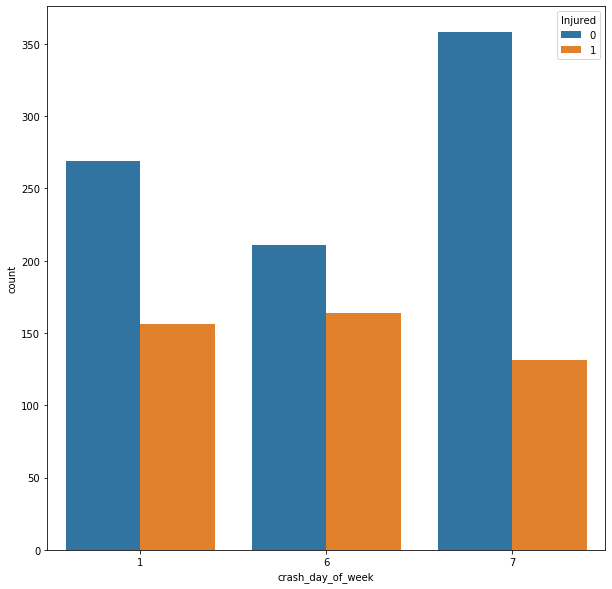

In [48]:
plt.figure(figsize=(10,10))
sns.countplot(x="crash_day_of_week", hue="Injured", data=df)

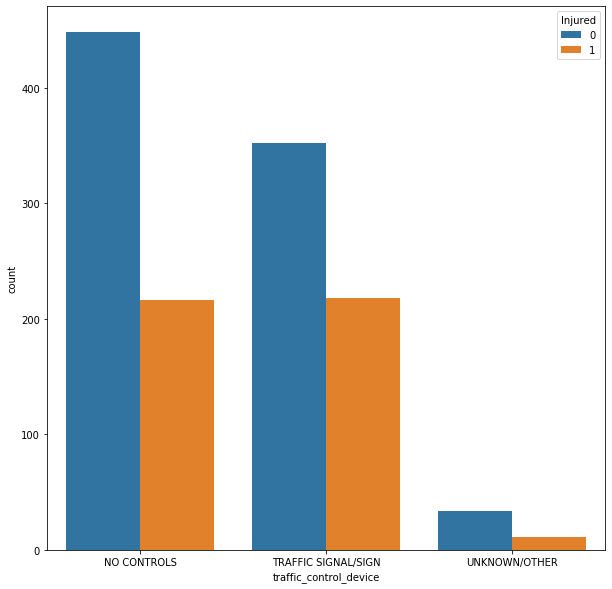

In [90]:
plt.figure(figsize=(10,10))
sns.countplot(x="traffic_control_device", hue="Injured", data=df)

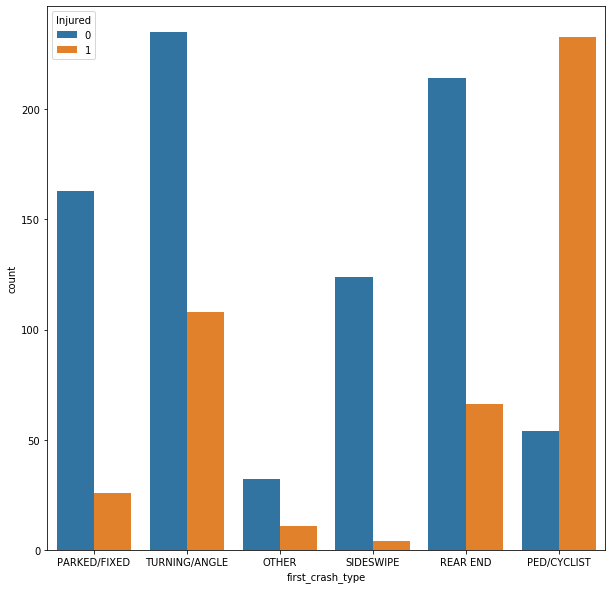

In [91]:
plt.figure(figsize=(10,10))
sns.countplot(x="first_crash_type", hue="Injured", data=df)

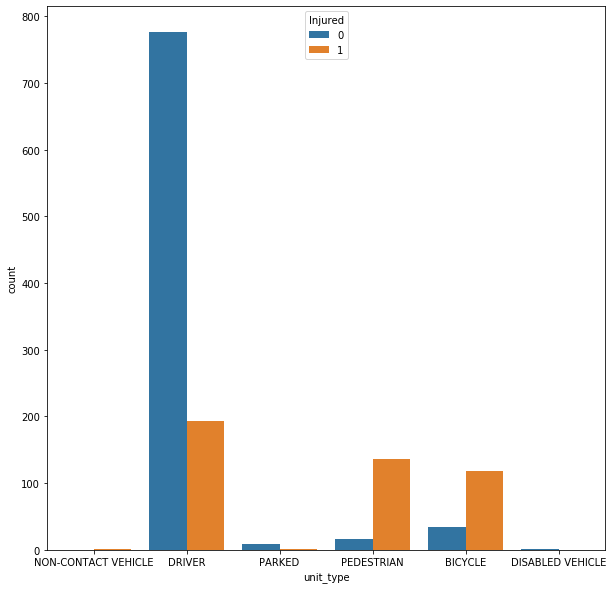

In [92]:
plt.figure(figsize=(10,10))
sns.countplot(x="unit_type", hue="Injured", data=df)

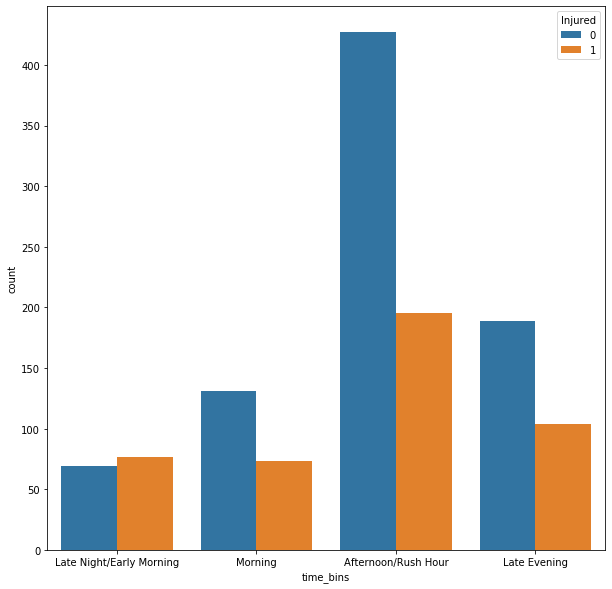

In [93]:
plt.figure(figsize=(10,10))
sns.countplot(x="time_bins", hue="Injured", data=df)

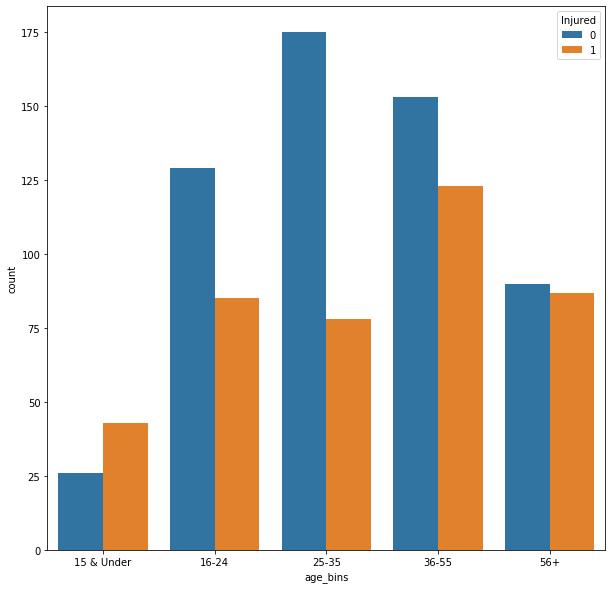

In [95]:
plt.figure(figsize=(10,10))
sns.countplot(x="age_bins", hue="Injured", data=df)

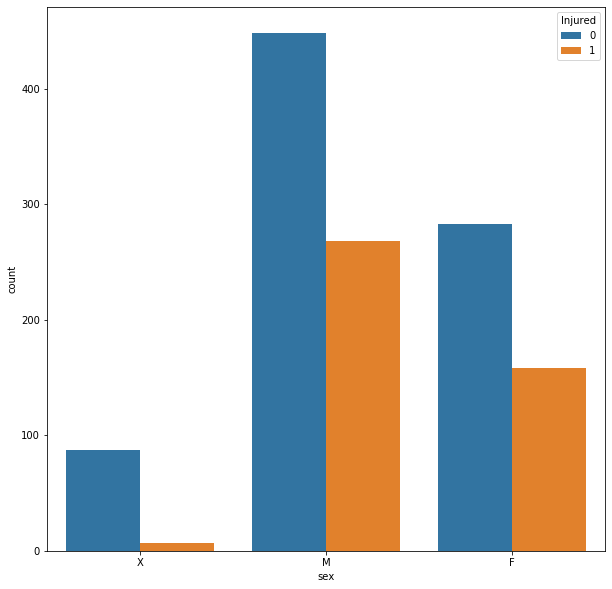

In [96]:
plt.figure(figsize=(10,10))
sns.countplot(x="sex", hue="Injured", data=df)

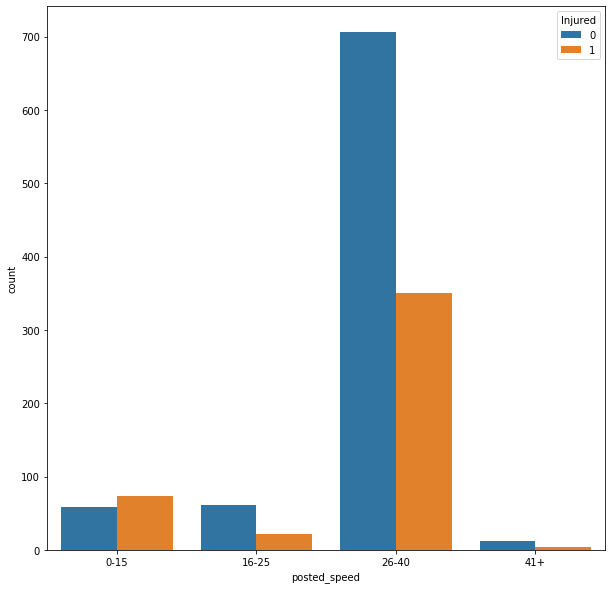

In [98]:
plt.figure(figsize=(10,10))
sns.countplot(x="posted_speed", hue="Injured", data=df)

In [49]:
# reviewing data 
df.describe()

,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,roadway_surface_cond,road_defect,hit_and_run_i,beat_of_occurrence,Injured,crash_day_of_week,unit_type,vehicle_type,sex,drivers_license_state,drivers_license_class,safety_equipment,airbag_deployed,driver_vision,time_bins,age_bins,posted_speed
count,1279,1287,1280,1289,1270,1286,1289,1286,402,1289,1289,1289,1289,982,1251,564,449,1251,983,1051,1265,989,1289
unique,3,3,2,6,6,7,4,2,2,203,2,3,6,5,3,16,11,3,3,3,4,5,4
top,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING/ANGLE,NOT DIVIDED,DRY,NO DEFECTS,Y,1135,0,7,DRIVER,PASSENGER,M,IL,D,SAFETY EQUIPMENT USED,NOT APPLICABLE/UNKNOWN,NOT OBSCURED,Afternoon/Rush Hour,36-55,26-40
freq,664,666,926,693,343,536,905,1007,384,40,838,489,969,636,716,514,401,533,443,614,622,276,1057


## Train-Test-Split


In [50]:
# setting X, y for train-test-split
target = 'Injured'
X = df.drop(columns= target)
y = df[target]

# train-test-split, test_size = 25%, random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

## Preprocessing Numerical 

In [51]:
# retrieving list of numeric columns 
num_cols = df.drop(columns=target).select_dtypes('number').columns.tolist()
num_cols

[]

In [52]:
# creating a pipeline 
# SimpleImputer will use the median to fill nulls  
# RobustScaler will use the median to scale 
num_transform = Pipeline([('imputer', SimpleImputer(strategy='median')),
                         ('scale', RobustScaler())])

## Preprocessing Categorical 

In [53]:
# retrieving list of categorical columns 
cat_cols = df.drop(columns=target).select_dtypes('object').columns.tolist()
cat_cols

['traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'first_crash_type',
 'trafficway_type',
 'roadway_surface_cond',
 'road_defect',
 'hit_and_run_i',
 'beat_of_occurrence',
 'crash_day_of_week',
 'unit_type',
 'vehicle_type',
 'sex',
 'drivers_license_state',
 'drivers_license_class',
 'safety_equipment',
 'airbag_deployed',
 'driver_vision']

In [54]:
# creating a pipeline
# SimpleImputer will use strategy 'constant' == 'missing value' input for objects
# OneHotEncoder will scale the categorical data to a binary column
cat_transform = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value="MISSING")),
                         ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

## ColumnTransformer

In [55]:
# combine both pipelines into one using columntransformer 
preprocessing = ColumnTransformer([('num', num_transform, num_cols), 
                                  ('cat', cat_transform, cat_cols)])

# preprocessing X_train and X_test
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)

In [56]:
# accessing categorical columns from pipeline then converting to dataframe
slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf

,traffic_control_device_MISSING,traffic_control_device_NO CONTROLS,traffic_control_device_TRAFFIC SIGNAL/SIGN,traffic_control_device_UNKNOWN/OTHER,device_condition_FUNCTIONING PROPERLY,device_condition_MISSING,device_condition_NO CONTROLS,device_condition_NOT FUNCTIONING/UNKNOWN,weather_condition_CLEAR,weather_condition_MISSING,weather_condition_RAIN/CLOUDY/OTHER,lighting_condition_DARKNESS,"lighting_condition_DARKNESS, LIGHTED ROAD",lighting_condition_DAWN,lighting_condition_DAYLIGHT,lighting_condition_DUSK,lighting_condition_UNKNOWN,first_crash_type_MISSING,first_crash_type_OTHER,first_crash_type_PARKED/FIXED,first_crash_type_PED/CYCLIST,first_crash_type_REAR END,first_crash_type_SIDESWIPE,first_crash_type_TURNING/ANGLE,trafficway_type_ALLEY/OTHER,trafficway_type_DIVIDED,trafficway_type_FOUR WAY,trafficway_type_MISSING,trafficway_type_NOT DIVIDED,trafficway_type_ONE-WAY,trafficway_type_PARKING LOT,trafficway_type_UNKNOWN,roadway_surface_cond_DRY,roadway_surface_cond_OTHER,roadway_surface_cond_UNKNOWN,roadway_surface_cond_WET,road_defect_MISSING,road_defect_NO DEFECTS,road_defect_UNKNOWN/OTHER,hit_and_run_i_MISSING,hit_and_run_i_N,hit_and_run_i_Y,beat_of_occurrence_1012,beat_of_occurrence_1013,beat_of_occurrence_1014,beat_of_occurrence_1022,beat_of_occurrence_1023,beat_of_occurrence_1024,beat_of_occurrence_1031,beat_of_occurrence_1034,beat_of_occurrence_111,beat_of_occurrence_1111,beat_of_occurrence_1112,beat_of_occurrence_1113,beat_of_occurrence_1114,beat_of_occurrence_1121,beat_of_occurrence_1122,beat_of_occurrence_1123,beat_of_occurrence_1124,beat_of_occurrence_113,beat_of_occurrence_1131,beat_of_occurrence_1132,beat_of_occurrence_1133,beat_of_occurrence_1135,beat_of_occurrence_114,beat_of_occurrence_1211,beat_of_occurrence_1214,beat_of_occurrence_1215,beat_of_occurrence_122,beat_of_occurrence_1221,beat_of_occurrence_1223,beat_of_occurrence_1224,beat_of_occurrence_1225,beat_of_occurrence_123,beat_of_occurrence_1231,beat_of_occurrence_1232,beat_of_occurrence_1235,beat_of_occurrence_124,beat_of_occurrence_131,beat_of_occurrence_132,beat_of_occurrence_1411,beat_of_occurrence_1414,beat_of_occurrence_1424,beat_of_occurrence_1432,beat_of_occurrence_1433,beat_of_occurrence_1511,beat_of_occurrence_1512,beat_of_occurrence_1513,beat_of_occurrence_1522,beat_of_occurrence_1533,beat_of_occurrence_1611,beat_of_occurrence_1612,beat_of_occurrence_1613,beat_of_occurrence_1622,beat_of_occurrence_1623,beat_of_occurrence_1624,beat_of_occurrence_1631,beat_of_occurrence_1632,beat_of_occurrence_1651,beat_of_occurrence_1654,beat_of_occurrence_1711,beat_of_occurrence_1712,beat_of_occurrence_1713,beat_of_occurrence_1722,beat_of_occurrence_1723,beat_of_occurrence_1724,beat_of_occurrence_1731,beat_of_occurrence_1732,beat_of_occurrence_1811,beat_of_occurrence_1812,beat_of_occurrence_1813,beat_of_occurrence_1814,beat_of_occurrence_1822,beat_of_occurrence_1823,beat_of_occurrence_1824,beat_of_occurrence_1832,beat_of_occurrence_1833,beat_of_occurrence_1834,beat_of_occurrence_1911,beat_of_occurrence_1912,beat_of_occurrence_1913,beat_of_occurrence_1921,beat_of_occurrence_1922,beat_of_occurrence_1924,beat_of_occurrence_1925,beat_of_occurrence_1931,beat_of_occurrence_1933,beat_of_occurrence_1934,beat_of_occurrence_1935,beat_of_occurrence_2011,beat_of_occurrence_2012,beat_of_occurrence_2022,beat_of_occurrence_2023,beat_of_occurrence_2032,beat_of_occurrence_211,beat_of_occurrence_212,beat_of_occurrence_214,beat_of_occurrence_215,beat_of_occurrence_2211,beat_of_occurrence_2212,beat_of_occurrence_2213,beat_of_occurrence_222,beat_of_occurrence_2221,beat_of_occurrence_2222,beat_of_occurrence_2223,beat_of_occurrence_223,beat_of_occurrence_2232,beat_of_occurrence_2233,beat_of_occurrence_2234,beat_of_occurrence_224,beat_of_occurrence_225,beat_of_occurrence_233,beat_of_occurrence_2411,beat_of_occurrence_2412,beat_of_occurrence_2413,beat_of_occurrence_2422,beat_of_occurrence_2423,beat_of_occurrence_2424,beat_of_occurrence_2431,beat_of_occurrence_2432,beat_of_occurrence_

## Class Imbalance (SMOTE)

In [99]:
# observing y_train(classes) count 
y_train.value_counts(normalize=True)

0    0.65942
1    0.34058
Name: Injured, dtype: float64

In [58]:
# # Using the SMOTE procedure to solve class imbalance problems 
# X_train_tf, y_train = SMOTE().fit_resample(X_train_tf, y_train)

In [59]:
# # reviewing SMOTE has been implemented 
# pd.Series(y_train).value_counts()

# Model 

## Logistic Regression 

In [60]:
# instantiate LogisticRegression 
log_reg = LogisticRegression()

### log_reg Vanilla Model 

In [61]:
# fit the model 
log_reg.fit(X_train_tf, y_train)

# predict
y_pred = log_reg.predict(X_test_tf)

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       637
           1       0.97      0.84      0.90       329

    accuracy                           0.94       966
   macro avg       0.95      0.91      0.93       966
weighted avg       0.94      0.94      0.94       966



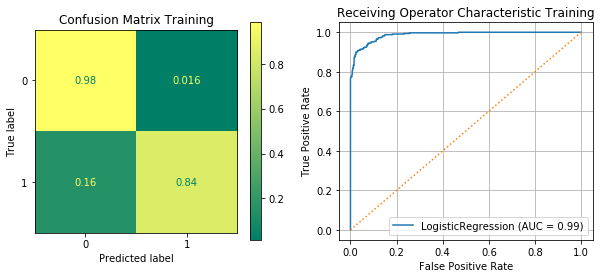

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       201
           1       0.94      0.78      0.85       122

    accuracy                           0.90       323
   macro avg       0.91      0.87      0.89       323
weighted avg       0.90      0.90      0.90       323



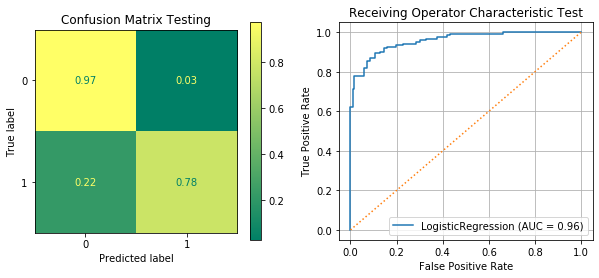

In [62]:
# classification report using function 
evaluate_classification(log_reg,X_train_tf, X_test_tf, y_train, y_test, label = "Logistic Regression")

### log_reg GridsearchCV

In [63]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score, pos_label="1")

In [64]:
# create params_grid for LogisticRegression 
params_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
               'penalty' : ['l1', 'l2', 'elasticnet', None]}
#add random state to params grid


# create grid search 
grid = GridSearchCV(log_reg, params_grid, cv=3, scoring=f1_scorer) 

# fit x_train and y_train to grid 
gridlock = grid.fit(X_train_tf, y_train)

# observe combination of best params 
gridlock.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       637
           1       0.96      0.84      0.90       329

    accuracy                           0.93       966
   macro avg       0.94      0.91      0.92       966
weighted avg       0.94      0.93      0.93       966



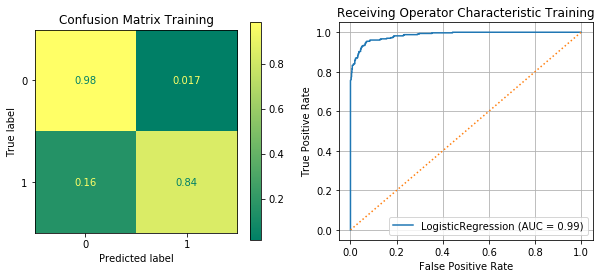

------------------------------------------------------------
Logistic Regression CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       201
           1       0.93      0.83      0.87       122

    accuracy                           0.91       323
   macro avg       0.91      0.89      0.90       323
weighted avg       0.91      0.91      0.91       323



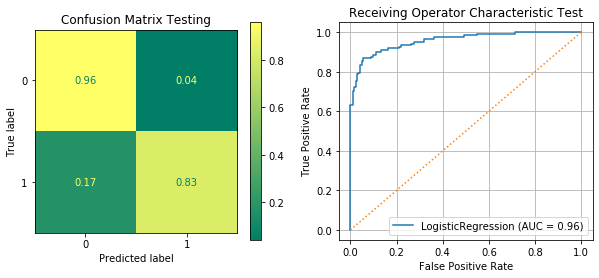

In [65]:
# classification report using function 
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label ="Logistic Regression")

## KNN Model 

In [66]:
# instantiate KneighborsClassifier 
knn_clf = KNeighborsClassifier()

### knn_clf Vanilla Model 

In [67]:
# fit the model 
knn_clf.fit(X_train_tf, y_train)

# predict
y_pred = knn_clf.predict(X_test_tf)

------------------------------------------------------------
KNN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       637
           1       0.91      0.84      0.88       329

    accuracy                           0.92       966
   macro avg       0.92      0.90      0.91       966
weighted avg       0.92      0.92      0.92       966



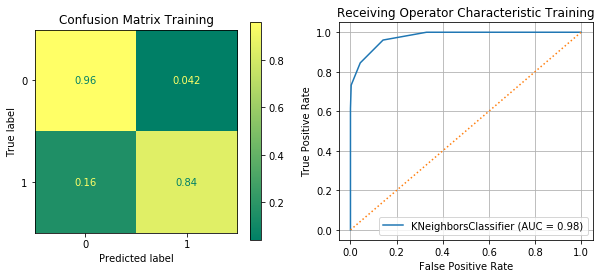

------------------------------------------------------------
KNN CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       201
           1       0.88      0.81      0.85       122

    accuracy                           0.89       323
   macro avg       0.89      0.87      0.88       323
weighted avg       0.89      0.89      0.89       323



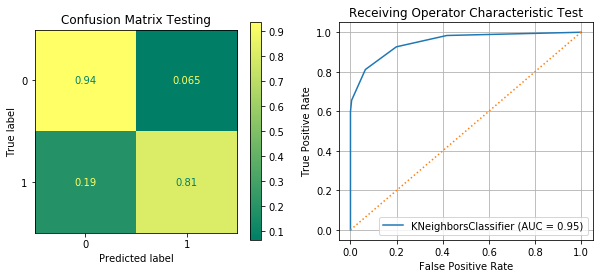

In [68]:
# classification report using function 
evaluate_classification(knn_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'KNN')

### knn_clf GridsearchCV

In [69]:
# create params_grid for KNeighborsClassifier  
params_grid = {'n_neighbors': [3, 5, 7, 9, 11, 21],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

# create grid search 
grid = GridSearchCV(knn_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

------------------------------------------------------------
KNN CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      0.99      1.00       329

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



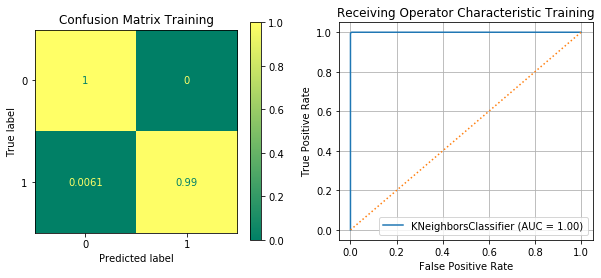

------------------------------------------------------------
KNN CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       201
           1       0.88      0.87      0.88       122

    accuracy                           0.91       323
   macro avg       0.90      0.90      0.90       323
weighted avg       0.91      0.91      0.91       323



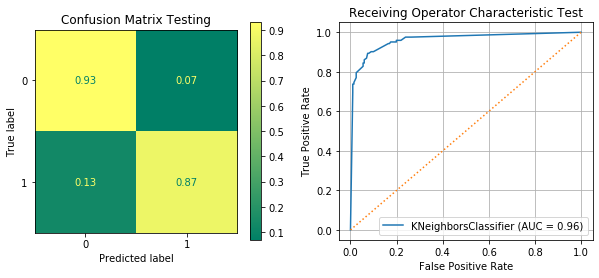

In [70]:
# classification report using function
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, label='KNN')

## Decision Tree

In [71]:
# instantiate DecisionTreeClassifier 
tree_clf = DecisionTreeClassifier()

### tree_clf Vanilla Model 

In [72]:
# fit the model  
tree_clf.fit(X_train_tf, y_train)

# predict 
y_pred = tree_clf.predict(X_test_tf)

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      0.99      1.00       329

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



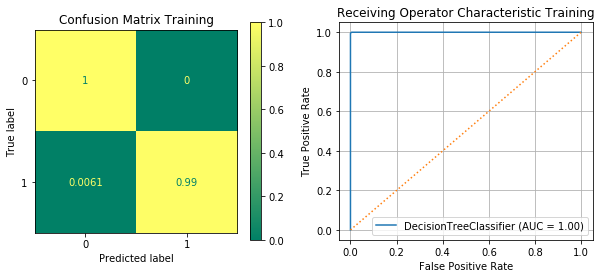

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       201
           1       0.86      0.88      0.87       122

    accuracy                           0.90       323
   macro avg       0.89      0.90      0.89       323
weighted avg       0.90      0.90      0.90       323



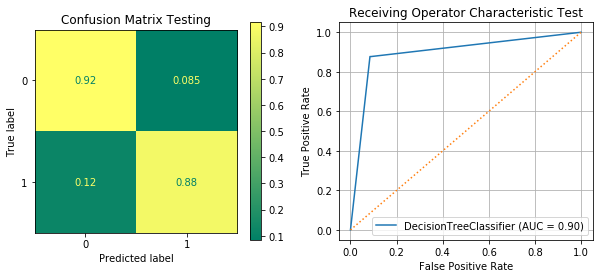

In [73]:
# classification report using function 
evaluate_classification(tree_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'Decision Tree')

### tree_clf GridsearchCV

In [74]:
# create params_grid for DecisionTreeClassifier  
params_grid = {'criterion': ['gini', 'entropy'], 
              'max_depth': [2,4,6,8,10,12,20, None],
              'min_samples_leaf':[1, 5, 10, 20, 50, 100]}

# create grid search 
grid = GridSearchCV(tree_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1}

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       637
           1       1.00      0.94      0.97       329

    accuracy                           0.98       966
   macro avg       0.99      0.97      0.98       966
weighted avg       0.98      0.98      0.98       966



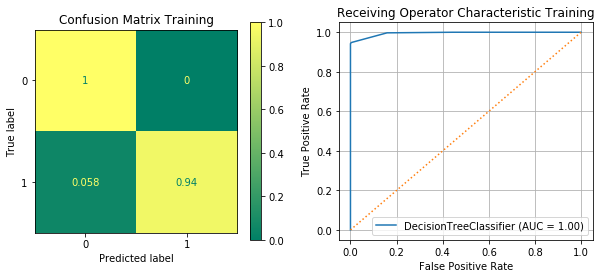

------------------------------------------------------------
Decision Tree CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       201
           1       0.91      0.82      0.86       122

    accuracy                           0.90       323
   macro avg       0.90      0.88      0.89       323
weighted avg       0.90      0.90      0.90       323



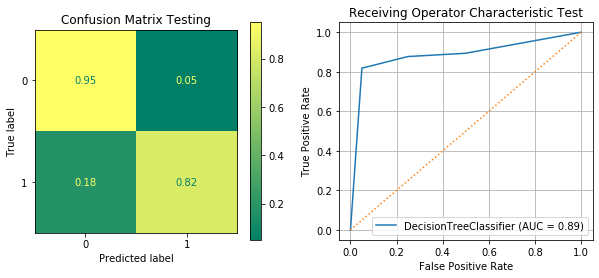

In [75]:
# classification report using function
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Decision Tree')

## Bagged Trees 

In [76]:
# instantiate Bagging + DecisionTreeClassifier  
bag_clf = BaggingClassifier(base_estimator=RandomForestClassifier())

### bag_clf Vanilla Model 

In [77]:
# fit the model  
bag_clf.fit(X_train_tf, y_train)

# predict
y_pred = bag_clf.predict(X_test_tf)

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       637
           1       1.00      0.95      0.98       329

    accuracy                           0.98       966
   macro avg       0.99      0.98      0.98       966
weighted avg       0.98      0.98      0.98       966



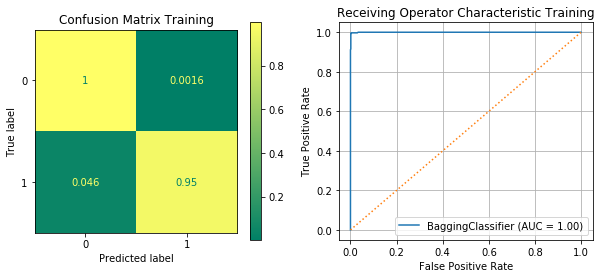

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       201
           1       0.98      0.70      0.81       122

    accuracy                           0.88       323
   macro avg       0.91      0.84      0.86       323
weighted avg       0.89      0.88      0.87       323



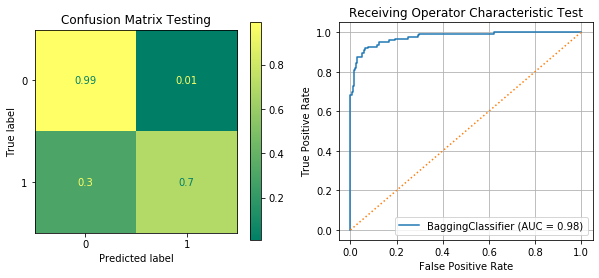

In [78]:
# classification report using function 
evaluate_classification(bag_clf, X_train_tf, X_test_tf, y_train, y_test, label = 'Bagged Trees')

### bag_clf GridsearchCV

In [79]:
# create params_grid for BaggingClassifier
params_grid = {'bootstrap': [True, False],
               'bootstrap_features': [True, False],    
               'n_estimators': [5, 10, 15],
               #'max_samples' : [0.6, 0.8, 1.0],
               'base_estimator__criterion': ['gini', 'entropy'],    
               'base_estimator__max_depth': [1, 5, 10, 15, None]}

# create grid search 
grid = GridSearchCV(bag_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': None,
 'bootstrap': False,
 'bootstrap_features': False,
 'n_estimators': 5}

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00       329

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



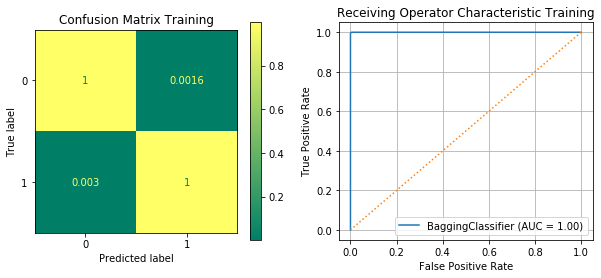

------------------------------------------------------------
Bagged Trees CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       201
           1       0.97      0.73      0.83       122

    accuracy                           0.89       323
   macro avg       0.91      0.86      0.87       323
weighted avg       0.90      0.89      0.88       323



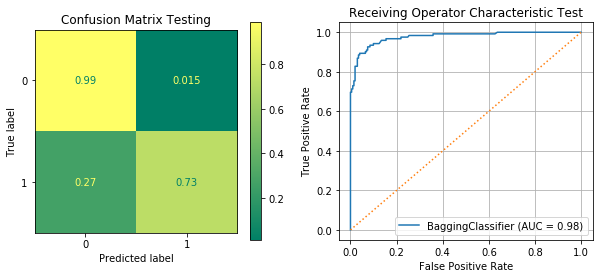

In [80]:
# classification report using function
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Bagged Trees')

## Random Forest 

In [81]:
# instantiate RandomForestClassifier  
forest_clf = RandomForestClassifier()

### forest_clf Vanilla Model 

In [82]:
# fit the model 
forest_clf.fit(X_train_tf, y_train)

# get prediction 
y_pred = forest_clf.predict(X_test_tf)

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00       329

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



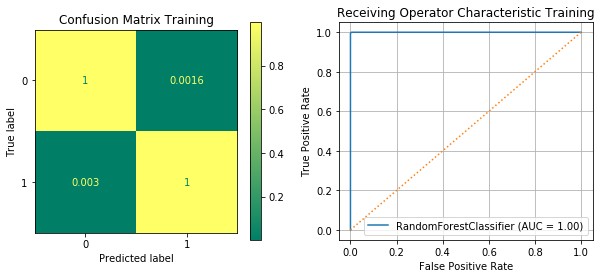

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       201
           1       0.97      0.73      0.83       122

    accuracy                           0.89       323
   macro avg       0.91      0.86      0.87       323
weighted avg       0.90      0.89      0.88       323



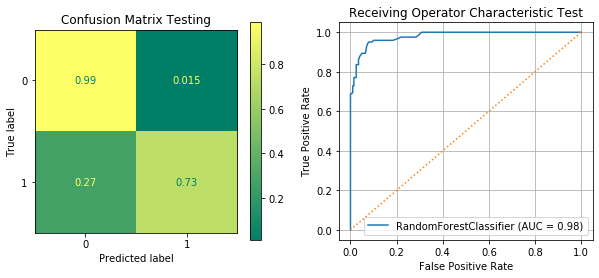

In [83]:
# classification report using function 
evaluate_classification(forest_clf,X_train_tf, X_test_tf, y_train, y_test, label = 'Random Forest')

### forest_clf GridsearchCV

In [84]:
# create params_grid for RandomForestClassifier 
params_grid = {'criterion': ['gini', 'entropy'],   
              'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

# create grid search 
grid = GridSearchCV(forest_clf, params_grid, cv=3)

# fit x_train and y_train to grid 
grid.fit(X_train_tf, y_train)

# observe combination of best params 
grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TRAINING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      0.99      1.00       329

    accuracy                           1.00       966
   macro avg       1.00      1.00      1.00       966
weighted avg       1.00      1.00      1.00       966



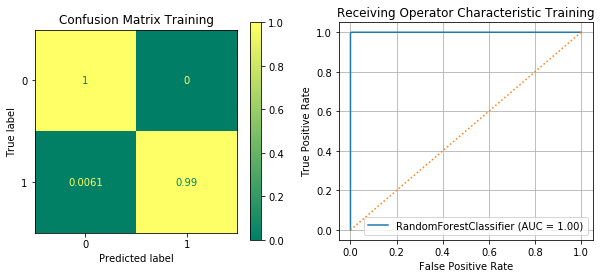

------------------------------------------------------------
Random Forest CLASSIFICATION REPORT TESTING 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       201
           1       0.97      0.81      0.88       122

    accuracy                           0.92       323
   macro avg       0.93      0.90      0.91       323
weighted avg       0.92      0.92      0.92       323



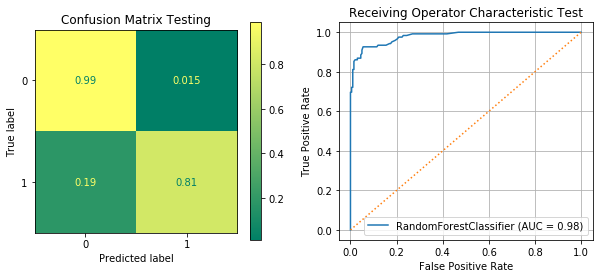

In [85]:
# classification report using function
evaluate_classification(grid.best_estimator_, X_train_tf, X_test_tf, y_train, y_test, 
                        label='Random Forest')

In [86]:
best_clf = grid.best_estimator_

# iNtrepretation

* Bagging Random Forest Classifier returned an accuracy rate of 89%
* Other models returned nearly the same accuracy rate or higher but decided with this one because the accuracy rate on the training level was not 100%. This will avoid overfitting to a degree.

In [87]:
# accessing categorical columns from pipeline then converting to dataframe
slice_pipe = preprocessing.named_transformers_['cat']
cat_features = slice_pipe.named_steps['encoder'].get_feature_names(cat_cols)
X_train_tf = pd.DataFrame(X_train_tf,columns=[*num_cols, *cat_features])
X_train_tf

,traffic_control_device_MISSING,traffic_control_device_NO CONTROLS,traffic_control_device_TRAFFIC SIGNAL/SIGN,traffic_control_device_UNKNOWN/OTHER,device_condition_FUNCTIONING PROPERLY,device_condition_MISSING,device_condition_NO CONTROLS,device_condition_NOT FUNCTIONING/UNKNOWN,weather_condition_CLEAR,weather_condition_MISSING,weather_condition_RAIN/CLOUDY/OTHER,lighting_condition_DARKNESS,"lighting_condition_DARKNESS, LIGHTED ROAD",lighting_condition_DAWN,lighting_condition_DAYLIGHT,lighting_condition_DUSK,lighting_condition_UNKNOWN,first_crash_type_MISSING,first_crash_type_OTHER,first_crash_type_PARKED/FIXED,first_crash_type_PED/CYCLIST,first_crash_type_REAR END,first_crash_type_SIDESWIPE,first_crash_type_TURNING/ANGLE,trafficway_type_ALLEY/OTHER,trafficway_type_DIVIDED,trafficway_type_FOUR WAY,trafficway_type_MISSING,trafficway_type_NOT DIVIDED,trafficway_type_ONE-WAY,trafficway_type_PARKING LOT,trafficway_type_UNKNOWN,roadway_surface_cond_DRY,roadway_surface_cond_OTHER,roadway_surface_cond_UNKNOWN,roadway_surface_cond_WET,road_defect_MISSING,road_defect_NO DEFECTS,road_defect_UNKNOWN/OTHER,hit_and_run_i_MISSING,hit_and_run_i_N,hit_and_run_i_Y,beat_of_occurrence_1012,beat_of_occurrence_1013,beat_of_occurrence_1014,beat_of_occurrence_1022,beat_of_occurrence_1023,beat_of_occurrence_1024,beat_of_occurrence_1031,beat_of_occurrence_1034,beat_of_occurrence_111,beat_of_occurrence_1111,beat_of_occurrence_1112,beat_of_occurrence_1113,beat_of_occurrence_1114,beat_of_occurrence_1121,beat_of_occurrence_1122,beat_of_occurrence_1123,beat_of_occurrence_1124,beat_of_occurrence_113,beat_of_occurrence_1131,beat_of_occurrence_1132,beat_of_occurrence_1133,beat_of_occurrence_1135,beat_of_occurrence_114,beat_of_occurrence_1211,beat_of_occurrence_1214,beat_of_occurrence_1215,beat_of_occurrence_122,beat_of_occurrence_1221,beat_of_occurrence_1223,beat_of_occurrence_1224,beat_of_occurrence_1225,beat_of_occurrence_123,beat_of_occurrence_1231,beat_of_occurrence_1232,beat_of_occurrence_1235,beat_of_occurrence_124,beat_of_occurrence_131,beat_of_occurrence_132,beat_of_occurrence_1411,beat_of_occurrence_1414,beat_of_occurrence_1424,beat_of_occurrence_1432,beat_of_occurrence_1433,beat_of_occurrence_1511,beat_of_occurrence_1512,beat_of_occurrence_1513,beat_of_occurrence_1522,beat_of_occurrence_1533,beat_of_occurrence_1611,beat_of_occurrence_1612,beat_of_occurrence_1613,beat_of_occurrence_1622,beat_of_occurrence_1623,beat_of_occurrence_1624,beat_of_occurrence_1631,beat_of_occurrence_1632,beat_of_occurrence_1651,beat_of_occurrence_1654,beat_of_occurrence_1711,beat_of_occurrence_1712,beat_of_occurrence_1713,beat_of_occurrence_1722,beat_of_occurrence_1723,beat_of_occurrence_1724,beat_of_occurrence_1731,beat_of_occurrence_1732,beat_of_occurrence_1811,beat_of_occurrence_1812,beat_of_occurrence_1813,beat_of_occurrence_1814,beat_of_occurrence_1822,beat_of_occurrence_1823,beat_of_occurrence_1824,beat_of_occurrence_1832,beat_of_occurrence_1833,beat_of_occurrence_1834,beat_of_occurrence_1911,beat_of_occurrence_1912,beat_of_occurrence_1913,beat_of_occurrence_1921,beat_of_occurrence_1922,beat_of_occurrence_1924,beat_of_occurrence_1925,beat_of_occurrence_1931,beat_of_occurrence_1933,beat_of_occurrence_1934,beat_of_occurrence_1935,beat_of_occurrence_2011,beat_of_occurrence_2012,beat_of_occurrence_2022,beat_of_occurrence_2023,beat_of_occurrence_2032,beat_of_occurrence_211,beat_of_occurrence_212,beat_of_occurrence_214,beat_of_occurrence_215,beat_of_occurrence_2211,beat_of_occurrence_2212,beat_of_occurrence_2213,beat_of_occurrence_222,beat_of_occurrence_2221,beat_of_occurrence_2222,beat_of_occurrence_2223,beat_of_occurrence_223,beat_of_occurrence_2232,beat_of_occurrence_2233,beat_of_occurrence_2234,beat_of_occurrence_224,beat_of_occurrence_225,beat_of_occurrence_233,beat_of_occurrence_2411,beat_of_occurrence_2412,beat_of_occurrence_2413,beat_of_occurrence_2422,beat_of_occurrence_2423,beat_of_occurrence_2424,beat_of_occurrence_2431,beat_of_occurrence_2432,beat_of_occurrence_

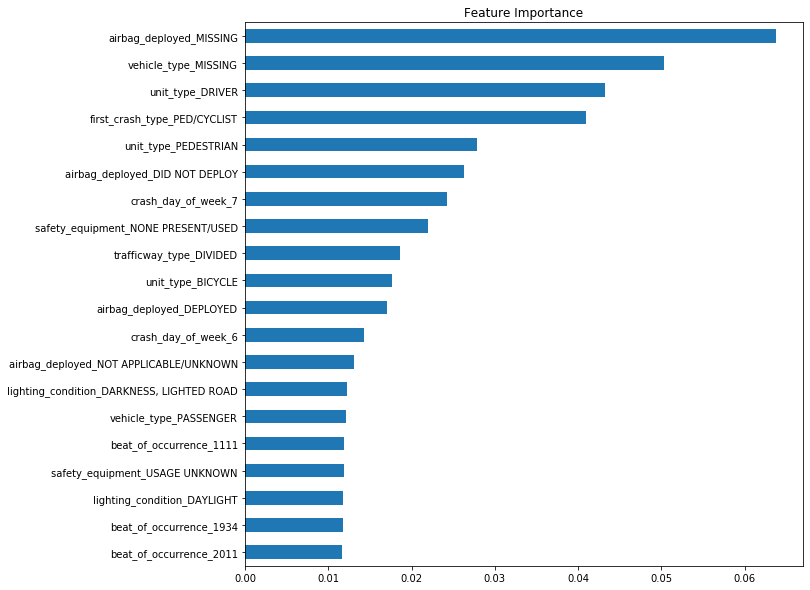

In [88]:
importance = pd.Series(best_clf.feature_importances_ ,index=X_train_tf.columns)
importance.sort_values().tail(20).plot(kind='barh', figsize=(10,10), title = 'Feature Importance')

> **Observations:**
   * Ped/Cyclist, driver, and pedestrians have the highest coefs with injuries/accidents

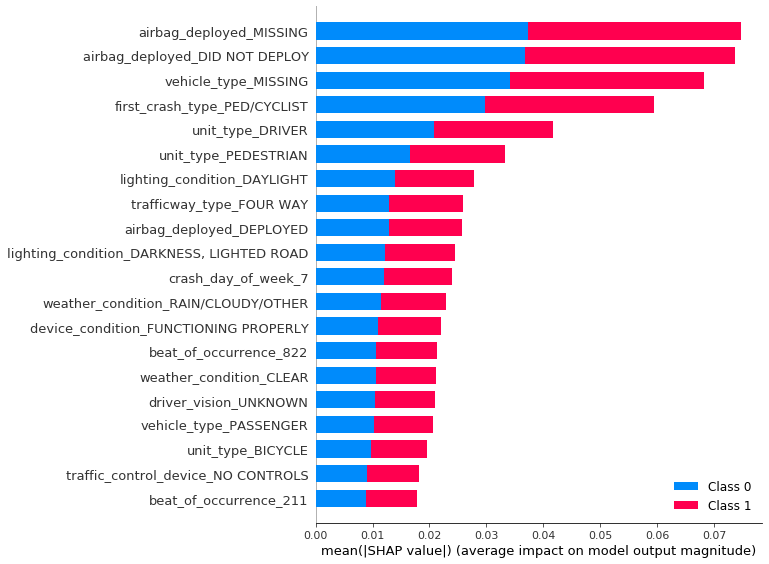

In [89]:
X_shap = shap.sample(X_train_tf,20)
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, plot_type="bar")

> **Observations:**
   * Most features have a 50/50 split with who is injured or not injured 
   * Missing information on type of vehicle involved 
   * Missing information on if airbag deployed or not 

# Conclusion 

Based on our classification model, the type of accidents that seem to occur the most is drivers colliding with pedestrians or cyclists on the street.   

Based on the data, it shows that pedestrians do not wear contrasting/reflective clothing and most accidents occur in the afternoon/rush hour. It also shows that most accidents occur in speed limit zones labeled between 30-40 mph. 

The following recommendations are;
 * Ped/Cyclist are more aware and wear contrasting colors during rush hour
 * The city can increase traffic signs and lanes that are more ped/cyclist friendly 
 * The city lowers the speed limit during afternoon/rush hour or more patrol in the 30-40 mph zones. 